In [12]:
#preprocessing
import numpy as np
import tensorflow as tf
from glob import glob

IMG_SIZE = (256,256)

def gen_example(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE)
    #print(img_path)
    label_path = img_path.replace('/images','/labels').replace('.jpg','.txt')
    #print(label_path)
    labels = np.loadtxt(label_path,delimiter=' ')
    label_wh = labels[:,[3,4]]
    label_xy = labels[:,[1,2]]
    boxes = np.hstack([label_xy-0.5*label_wh,label_xy+0.5*label_wh])
    boxes = boxes*(img.shape[:2]+img.shape[:2])
    K_loc = 0.5*(boxes[:,[2,3]]+boxes[:,[0,1]])
    K_bw = 0.5*(boxes[:,[2,3]]-boxes[:,[0,1]])
    ys, xs = np.ogrid[0:img.shape[0]:IMG_SIZE[0]*1j, 0:img.shape[1]:IMG_SIZE[1]*1j]
    dens = 0
    for (loc_x,loc_y),(bw_x,bw_y) in zip(K_loc,K_bw):
        bw_x, bw_y = 10,10 # use constant rather than actual size for simplicity
        dens_update = np.clip(1-np.abs(loc_x-xs)/bw_x,0,1)*np.clip(1-np.abs(loc_y-ys)/bw_y,0,1)
        dens = dens + dens_update
    return img,dens


def gen_data(subpath='train'):
    def gen():
        for img_path in glob(f'dataset/{subpath}/images/*.jpg'):
            img,dens = gen_example(img_path)
            yield img,dens
    return gen

test_ds = tf.data.Dataset.from_generator(
     gen_data('test'),
     output_signature=(
         tf.TensorSpec(shape=IMG_SIZE+(3,), dtype=tf.float32),
         tf.TensorSpec(shape=IMG_SIZE, dtype=tf.float32)
    )
)
test_ds = test_ds.batch(32).prefetch(1).cache()

In [13]:
from keras.models import load_model
model = load_model('treesense.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      9632      
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      36928     
                                                        

In [14]:
from sklearn.metrics import r2_score

imgs_pred = model.predict(test_ds)
imgs_dens = np.stack( [dens for _,dens in test_ds.unbatch().as_numpy_iterator()] )

1/1 [==============================] - 1s 605ms/step


In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
y_true=imgs_dens.ravel()
y_pred=imgs_pred.ravel()
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2=r2_score(y_true, y_pred)
print("MSE : ",mse)
print("MAE : ",mae)
print("RMSE : ",rmse)
print("R2-Score : ",r2)

MSE :  0.013211451
MAE :  0.055470157
RMSE :  0.114941075
R2-Score :  0.7667292809673655


1/1 [==============================] - 0s 158ms/step


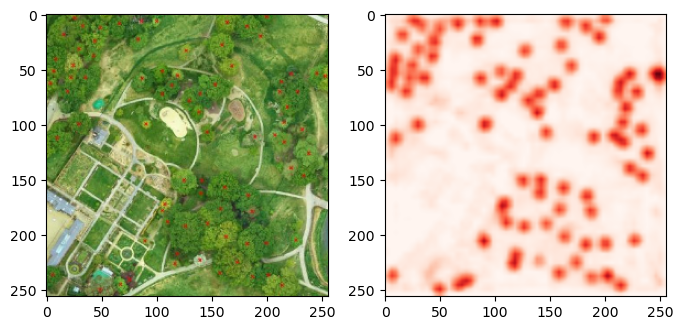

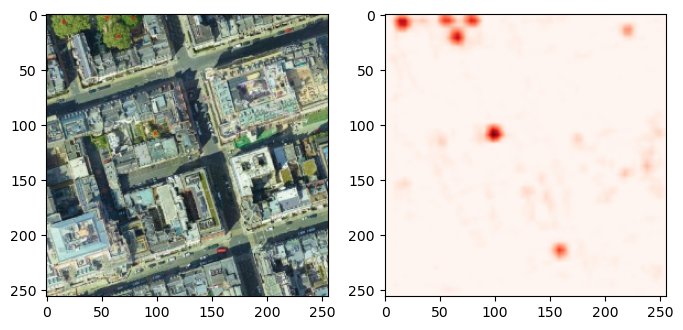

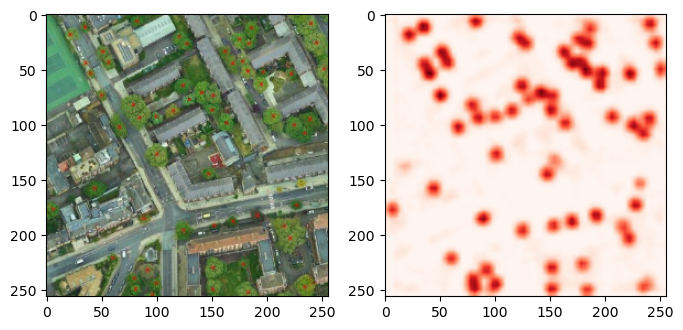

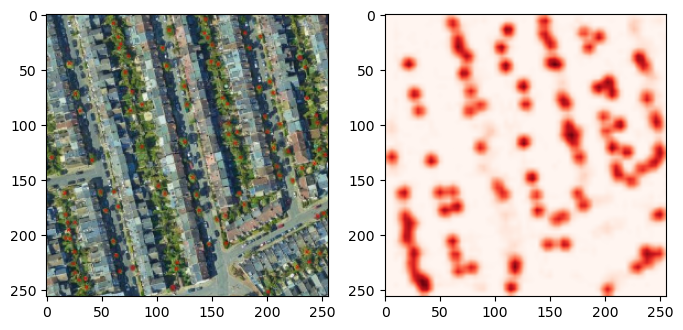

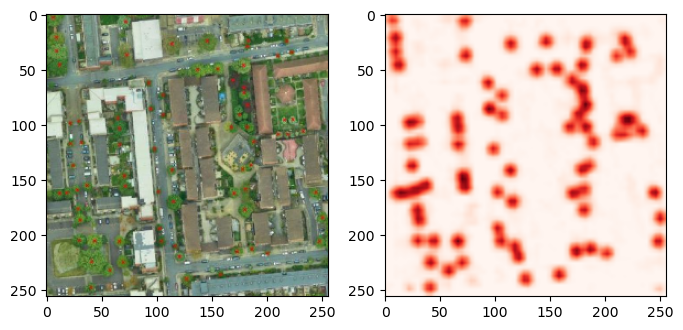

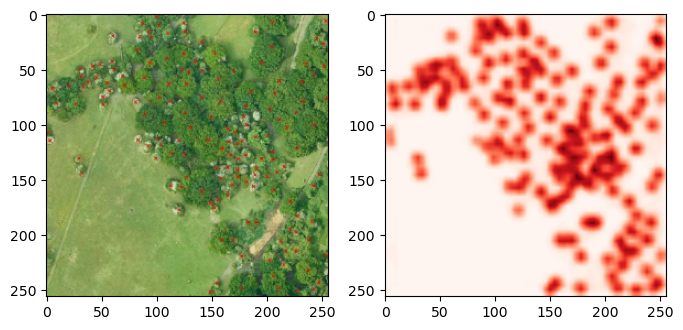

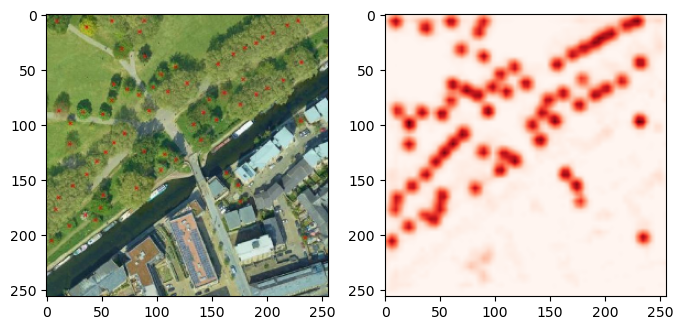

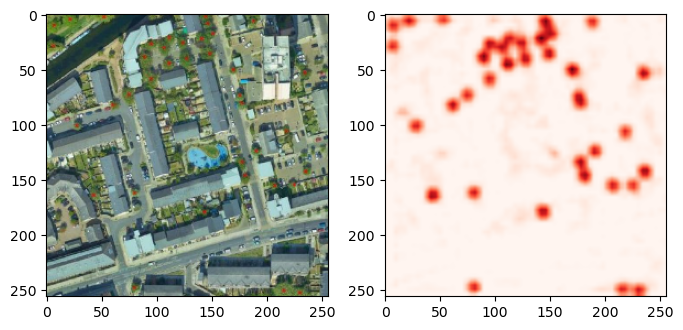

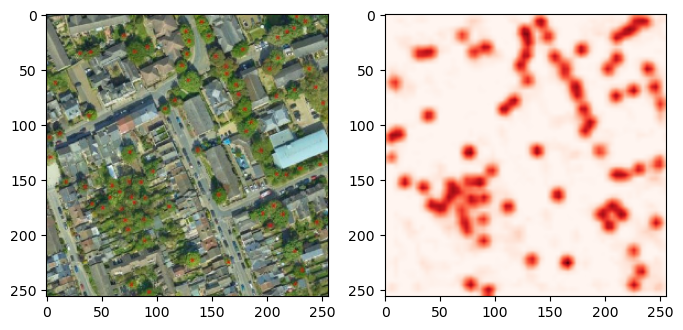

In [16]:
import matplotlib.pyplot as plt
imgs_pred = model.predict(test_ds)
for img_pred,(img,_) in zip(imgs_pred,test_ds.unbatch().as_numpy_iterator()):
    fig,axs = plt.subplots(1,2,figsize=(8,4))
    axs[0].imshow(img)
    axs[1].imshow( img_pred, cmap="Reds" )
    plt.show()

In [17]:
from sklearn.linear_model import LinearRegression
import seaborn as sns

tree_cnt = []
subpath = 'test'
for img_path in glob(f'dataset/{subpath}/images/*.jpg'):
    label_path = img_path.replace('/images','/labels').replace('.jpg','.txt')
    labels = np.loadtxt(label_path,delimiter=' ')
    tree_cnt.append(len(labels))
tree_cnt = np.array(tree_cnt)
total_dens_pred = tf.reduce_sum(imgs_pred, axis=[1,2,3]).numpy()
density_constant = LinearRegression().fit(total_dens_pred.reshape(-1,1),tree_cnt).coef_[0]
total_dens_pred = tf.reduce_sum(imgs_pred, axis=[1,2,3]).numpy()
predicted_treecount=[int(count) for count in total_dens_pred*density_constant]


In [18]:
density_constant

0.0119316755

In [19]:
predicted_treecount

[118, 15, 85, 118, 94, 171, 88, 52, 105]

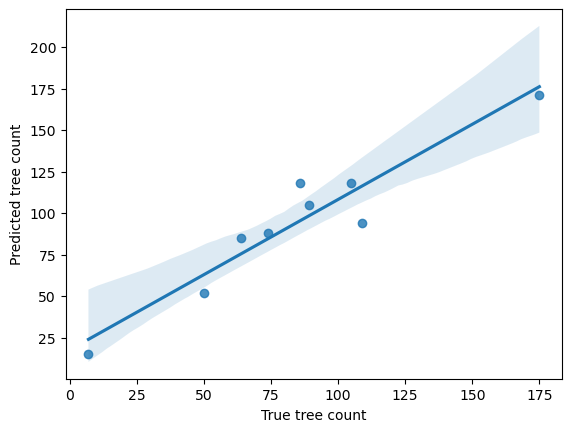

In [20]:
fig,ax = plt.subplots()
sns.regplot(x=tree_cnt,y=predicted_treecount,ax=ax)
ax.set_xlabel('True tree count')
ax.set_ylabel('Predicted tree count')
plt.show()

In [21]:
img_path="C:\\Users\\Hp-admin\\Desktop\\python\\2024\\TreeSensingSatelliteImage\\dataset\\train\\images\\bs_261922_4_174326_4_19_jpg.rf.52ea7e691f00b8b76e0e794fea7dc344.jpg"
img = tf.io.read_file(img_path)
img = tf.io.decode_jpeg(img)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, IMG_SIZE)
input_array = tf.keras.preprocessing.image.img_to_array(img)
input_array = tf.expand_dims(input_array, 0) 
imgs_pred_single = model.predict(input_array)
total_dens_pred_single = tf.reduce_sum(imgs_pred_single, axis=[1,2,3]).numpy()
predicted_treecount_single=[int(count) for count in total_dens_pred_single*density_constant]
predicted_treecount_single

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: C:\Users\Hp-admin\Desktop\python\2024\TreeSensingSatelliteImage\dataset\train\images\bs_261922_4_174326_4_19_jpg.rf.52ea7e691f00b8b76e0e794fea7dc344.jpg : The system cannot find the path specified.
; No such process [Op:ReadFile]